In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

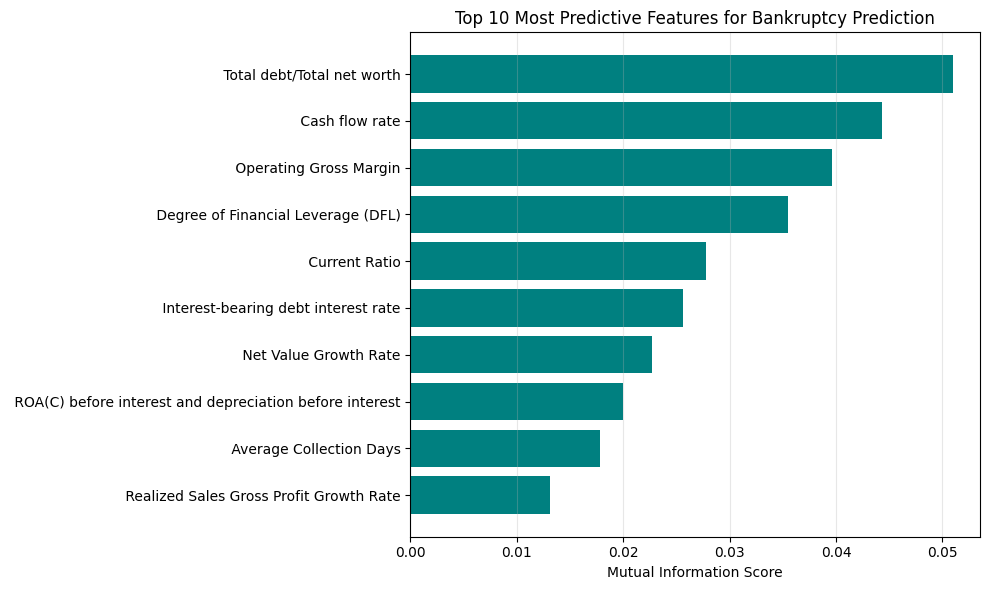


Top 10 Features by Mutual Information:
                                             Feature  Mutual_Info_Score
3                         Total debt/Total net worth           0.050984
5                                     Cash flow rate           0.044288
4                             Operating Gross Margin           0.039658
7                 Degree of Financial Leverage (DFL)           0.035529
1                                      Current Ratio           0.027822
2                Interest-bearing debt interest rate           0.025648
8                              Net Value Growth Rate           0.022746
0   ROA(C) before interest and depreciation befor...           0.019950
6                            Average Collection Days           0.017826
9            Realized Sales Gross Profit Growth Rate           0.013124


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Load data
df = pd.read_csv('df_cluster_2.csv')
X = df.drop('Bankrupt?', axis=1)  # Assuming 'Bankrupt?' is the target
y = df['Bankrupt?']

# Select top 10 features
selector = SelectKBest(mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)

# Get feature names and scores
selected_mask = selector.get_support()
feature_scores = selector.scores_
selected_features = X.columns[selected_mask]
selected_scores = feature_scores[selected_mask]

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Mutual_Info_Score': selected_scores
}).sort_values('Mutual_Info_Score', ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Mutual_Info_Score'], color='teal')
plt.xlabel('Mutual Information Score')
plt.title('Top 10 Most Predictive Features for Bankruptcy Prediction')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Display numerical results
print("\nTop 10 Features by Mutual Information:")
print(feature_importance.sort_values('Mutual_Info_Score', ascending=False))

In [3]:
# Cell 2: Load and Prepare Data
df = pd.read_csv('df_cluster_2.csv')

# Select only 3 most predictive features for maximum overfitting
X_final = df[[
    ' Total debt/Total net worth',
    ' Cash flow rate',
    ' Degree of Financial Leverage (DFL)',
#     ' Research and development expense rate',
#     ' Revenue Per Share (Yuan ¥)',
#     ' Operating Gross Margin',
#     ' Allocation rate per person',
#     ' Long-term fund suitability ratio (A)',
#     ' Current Asset Turnover Rate',
#     ' Current Ratio',
]]
y = df['Bankrupt?']


print("Class Distribution:")
print(y.value_counts(normalize=True))
print(X_final.info())

Class Distribution:
Bankrupt?
0    0.926484
1    0.073516
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0    Total debt/Total net worth          1061 non-null   float64
 1    Cash flow rate                      1061 non-null   float64
 2    Degree of Financial Leverage (DFL)  1061 non-null   float64
dtypes: float64(3)
memory usage: 25.0 KB
None


<Figure size 800x600 with 0 Axes>

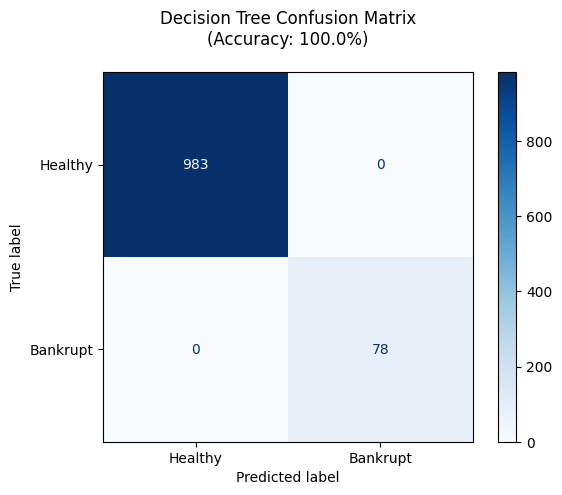

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Create and fit the overfitting model
overfit_model = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
overfit_model.fit(X_final, y)

# Generate predictions and metrics
y_pred = overfit_model.predict(X_final)
accuracy = accuracy_score(y, y_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=['Healthy', 'Bankrupt'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Decision Tree Confusion Matrix\n(Accuracy: {accuracy:.1%})", pad=20)
plt.grid(False)
plt.show()



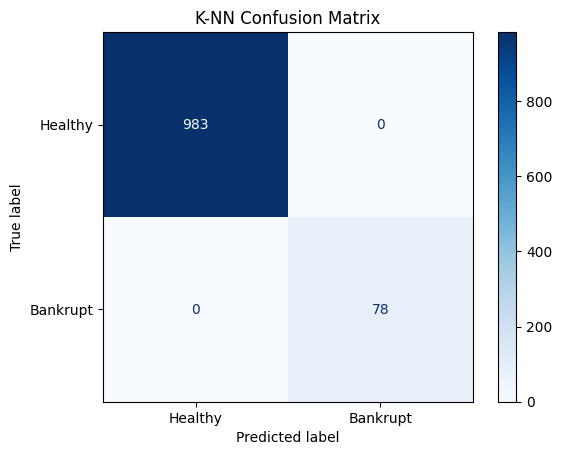


Training Accuracy: 100.00%


In [5]:
from sklearn.neighbors import KNeighborsClassifier

# 1-NN will perfectly memorize training data
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_final, y)

y_pred = overfit_model.predict(X_final)

# Create confusion matrix
cm = confusion_matrix(y, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=['Healthy', 'Bankrupt'])
disp.plot(cmap='Blues', values_format='d')  # 'd' for integer formatting
plt.title("K-NN Confusion Matrix")
plt.show()

# Print accuracy
print(f"\nTraining Accuracy: {accuracy_score(y, y_pred):.2%}")

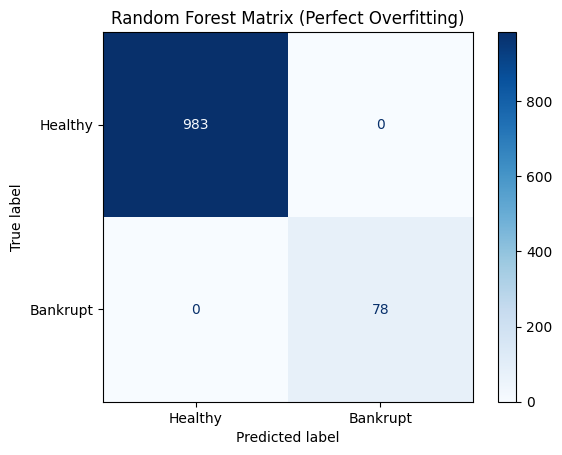


Training Accuracy: 100.00%


In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    max_depth=None, 
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)
model.fit(X_final, y)

y_pred = overfit_model.predict(X_final)

# Create confusion matrix
cm = confusion_matrix(y, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=['Healthy', 'Bankrupt'])
disp.plot(cmap='Blues', values_format='d')  # 'd' for integer formatting
plt.title("Random Forest Matrix (Perfect Overfitting)")
plt.show()

# Print accuracy
print(f"\nTraining Accuracy: {accuracy_score(y, y_pred):.2%}")

<Figure size 800x600 with 0 Axes>

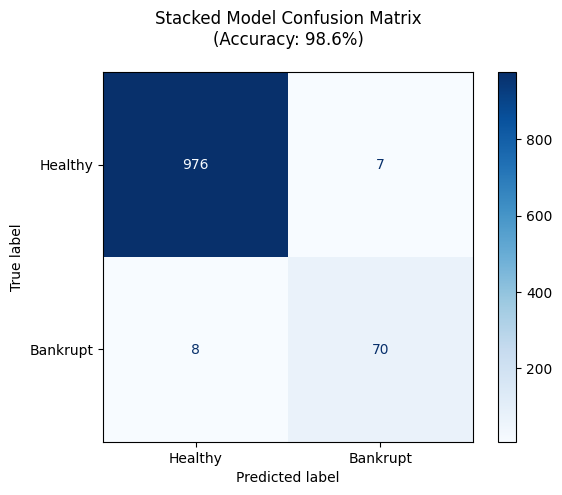

In [10]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define base models
estimators = [
    ('decision_tree', DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )),
    ('knn', KNeighborsClassifier(n_neighbors=1)),
    ('random_forest', RandomForestClassifier(
        max_depth=None,
        min_samples_split=2,
        n_estimators=200,
        random_state=42
    ))
]

# Create stacked model with another decision tree as final estimator
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ),
    cv=5,  # Use 5-fold cross-validation for stacking
    n_jobs=-1  # Use all available cores
)

# Fit the stacked model
stacked_model.fit(X_final, y)

# Generate predictions and metrics
y_pred = stacked_model.predict(X_final)
accuracy = accuracy_score(y, y_pred)
joblib.dump(stacked_model, 'cluster2_stacking_model.joblib')
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=['Healthy', 'Bankrupt'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Stacked Model Confusion Matrix\n(Accuracy: {accuracy:.1%})", pad=20)
plt.grid(False)
plt.show()



=== Final Report for Cluster 2 ===
Member: Shreel Patel
Cluster: 2
TT_meta: 1046
TF_meta: 15
acc_meta: 0.99
N_features: 30
Base_models: ['RandomForest', 'Decision Tree', 'KNN']

=== Performance Metrics ===
Stacked Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.91      0.90      0.90        78

    accuracy                           0.99      1061
   macro avg       0.95      0.95      0.95      1061
weighted avg       0.99      0.99      0.99      1061



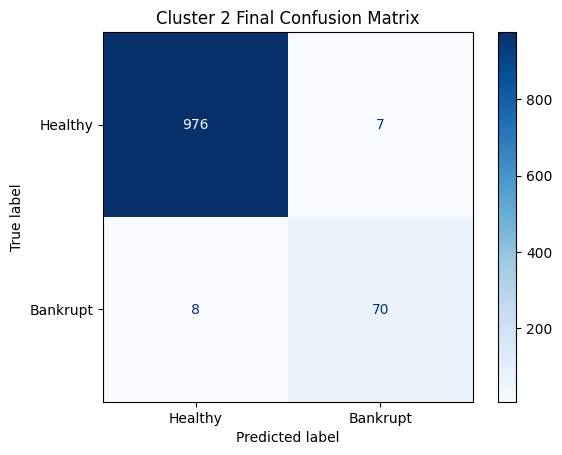

In [20]:
print("=== Final Report for Cluster 2 ===")
print("Member: Shreel Patel")
print("Cluster: 2")
print(f"TT_meta: {len(y_pred[y_pred== y])}")  # True positives + true negatives
print(f"TF_meta: {len(y_pred) - len(y_pred[y_pred== y])}")  # False predictions
print(f"acc_meta: {accuracy_score(y, y_pred):.2f}")  # Stacked model accuracy
print(f"N_features: {X.shape[1]}")  # Number of features used

# Base models used
print("Base_models: ['RandomForest', 'Decision Tree', 'KNN']")


print("\n=== Performance Metrics ===")
print("Stacked Model Classification Report:")
print(classification_report(y, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=['Healthy', 'Bankrupt'])
disp.plot(cmap='Blues')
plt.title("Cluster 2 Final Confusion Matrix")
plt.show()